Tutorials of CPS using HBC dataset
===
**Interpretations of attention scores**
1. read the dataset
2. construct the graph (construct the multi-scale features, option)
2. train the model
3. generate the arbitrary resolution spots
4. visualize the results

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = False
args.sh_weights = False
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/4-Human_Breast_Cancer'
args.radius=300
args.clusters=20
args.self_loops=True
args.max_epoch=1000
# args.hvgs=3000
CPS.set_random_seed(args.seed)
args

Namespace(batch_size=256, clusters=20, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/4-Human_Breast_Cancer', decoder='MLP', decoder_latent=[256, 512], distill=1.0, dropout=0.2, flow='source_to_target', freq=8, gpu=0, hvgs=2000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=6, n_spot=0, num_heads=4, prep_scale=False, radius=300, seed=2025, self_loops=True, sh_weights=False, sigma=1.0, visual=True, weight_decay=0.0001)

Read the adata

In [4]:
adata = sc.read_visium(path=args.dataset_path, count_file='filtered_feature_bc_matrix.h5')
Ann_df = pd.read_csv(os.path.join(args.dataset_path, 'metadata.tsv'), sep='\t', header=0, index_col=0)
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'ground_truth']
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Preprocess adata

In [5]:
adata.var_names_make_unique()

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
sc.pp.normalize_total(adata, target_sum=1e4)
adata.layers["counts"] = adata.X.copy()
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=True, max_value=10)

adata_hvg = adata[:, adata.var['highly_variable']].copy()
counts_layer = adata_hvg.layers['counts']

adata.obsm['hvg_features'] = adata_hvg.X
adata.obsm['hvg_counts'] = counts_layer.toarray()

In [6]:
# adata.var_names_make_unique()
# sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
# sc.pp.normalize_total(adata, target_sum=1e4)
# # sc.pp.log1p(adata)
# # sc.pp.scale(adata, zero_center=True, max_value=10)

# adata_hvg = adata[:, adata.var['highly_variable']].copy()
# adata.obsm['hvg_features'] = adata_hvg.X.toarray()

Construct the spatial graph

In [7]:
spatial_edge = CPS.SpatialGraphBuilder(args)
pyg_data = spatial_edge.build_single_graph(adata, method='rknn')
print(pyg_data.num_nodes, pyg_data.num_genes, pyg_data.edge_index.shape)

3798 2000 torch.Size([2, 25862])


Train the CPS model

In [8]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(pyg_data)

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch   0: Train[Total:31.6066, T:15.4180, S:15.4147, D:0.7740]

Epoch  10: Train[Total:25.2218, T:12.1541, S:12.1884, D:0.8793]

Epoch  20: Train[Total:20.5871, T:9.7744, S:10.0744, D:0.7383]

Epoch  30: Train[Total:17.3193, T:7.9558, S:8.6632, D:0.7003]

Epoch  40: Train[Total:14.4806, T:6.2878, S:7.4717, D:0.7211]

Epoch  50: Train[Total:12.2904, T:4.9981, S:6.5272, D:0.7651]

Epoch  60: Train[Total:10.7096, T:4.0821, S:5.8177, D:0.8098]

Epoch  70: Train[Total:9.8982, T:3.5943, S:5.4584, D:0.8455]

Epoch  80: Train[Total:9.4214, T:3.3151, S:5.2241, D:0.8822]

Epoch  90: Train[Total:9.1280, T:3.1164, S:5.1225, D:0.8891]

Epoch 100: Train[Total:8.7678, T:3.0059, S:4.8295, D:0.9324]

Epoch 110: Train[Total:8.5762, T:2.9156, S:4.7133, D:0.9473]

Epoch 120: Train[Total:8.4161, T:2.8234, S:4.6084, D:0.9843]

Epoch 130: Train[Total:8.2753, T:2.7606, S:4.5412, D:0.9735]

Epoch 140: Train[Total:8.0971, T:2.7152, S:4.4193, D:0.9626]

Epoch 150: Train[Total:8.0276, T:2.7020, S:4.3681, D:0.95

Downstream analysis

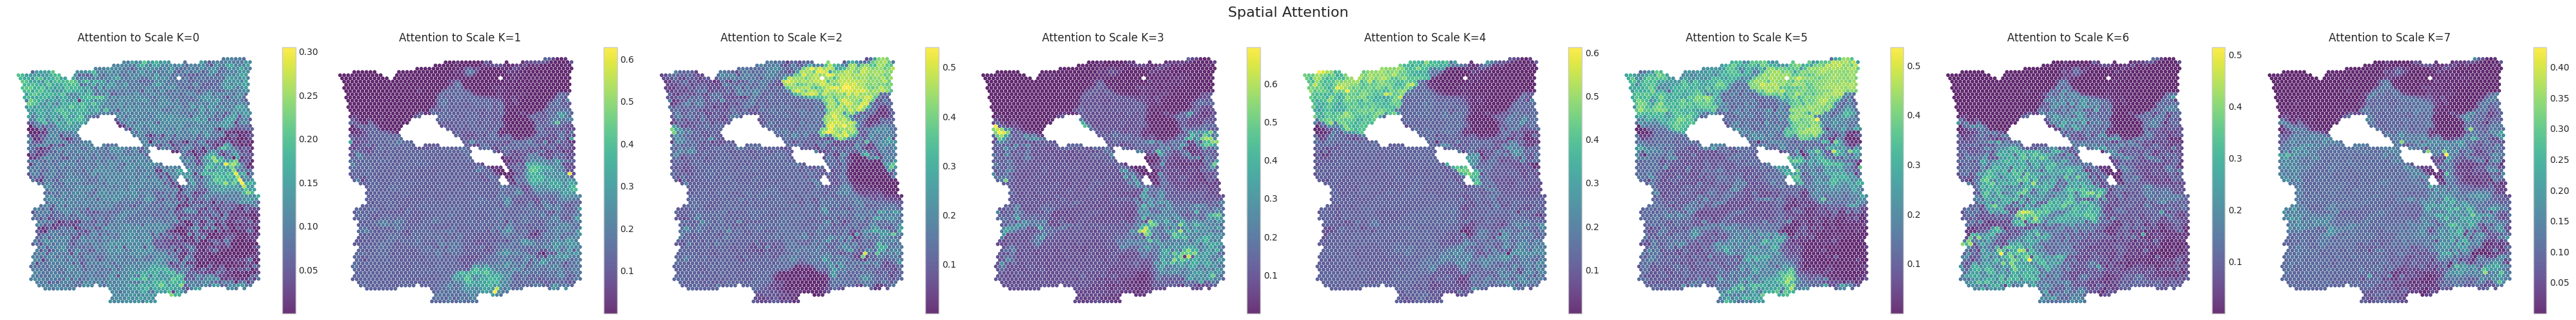

In [9]:
z_s, latent, attn, fig = cps_model.interpret_attn_scores(pyg_data, return_fig=True)
adata.obsm['z_s'] = z_s
adata.obsm['z_t'] = latent
adata.obsm['attns'] = attn

In [10]:
adata.obsm['attns'].shape, adata.obsm['z_t'].shape

((3798, 8, 4), (3798, 64))

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


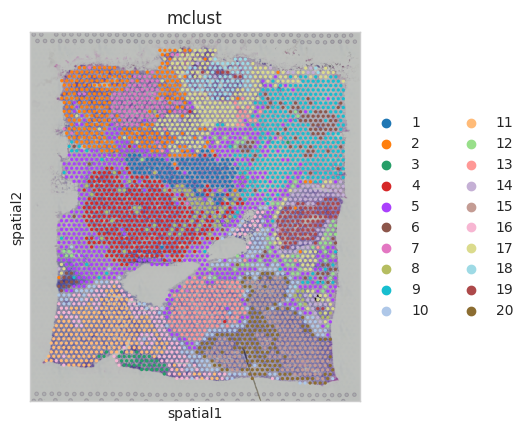

In [11]:
adata = CPS.mclust(adata, args, key='z_t', pca_dim=32)
sc.pl.spatial(adata, img_key="hires", color=["mclust"])

fitting ...
  |======================================================================| 100%


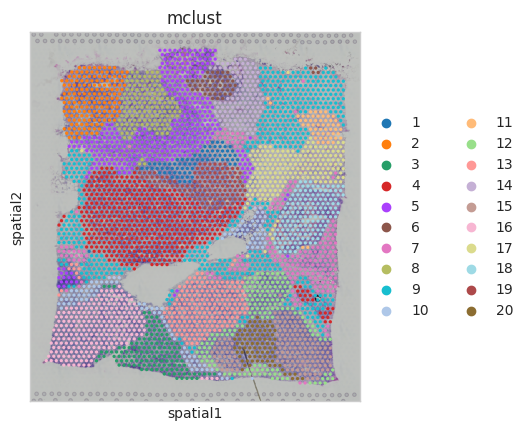

In [12]:
adata = CPS.mclust(adata, args, key='z_s', pca_dim=32)
sc.pl.spatial(adata, img_key="hires", color=["mclust"])

fitting ...
  |======================================================================| 100%


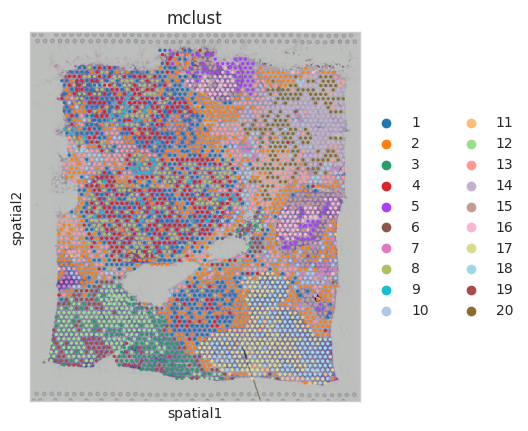

In [13]:
adata.obsm['attn'] = attn.reshape(adata.n_obs, 32)
adata = CPS.mclust(adata, args, key='attn', pca_dim=16)
sc.pl.spatial(adata, img_key="hires", color=["mclust"])

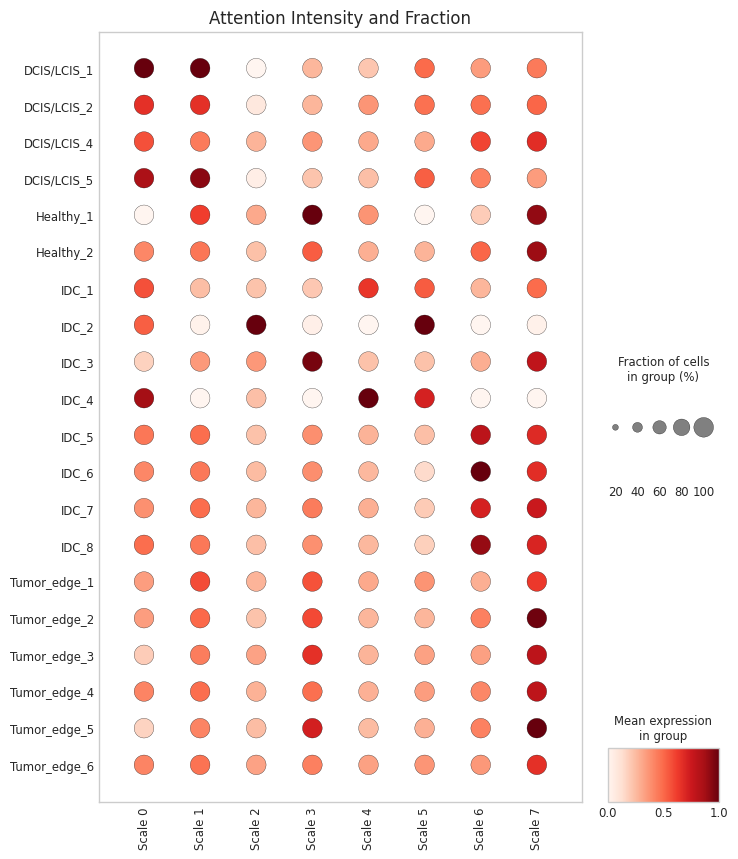

In [14]:
attn = np.mean(attn, axis=2)
adata.obsm['attn'] = attn
import scanpy as sc
import pandas as pd
import numpy as np

# 1. 提取数据
# 假设 adata.obsm['attn'] 的形状是 (n_cells, n_scales)
attn_data = adata.obsm['attn']
n_scales = attn_data.shape[1]

# 2. 构建临时的 AnnData 对象
# 我们将 attention score 当作 "基因" 放入 X 中
adata_attn = sc.AnnData(X=attn_data)

# 3. 转移元数据 (Obs)
# 必须把 Ground Truth 标签复制过来，用于分组
adata_attn.obs['Ground Truth'] = adata.obs['Ground Truth'].values

# 4. 命名变量 (Var)
# 给每一个尺度起个名字，这将成为横轴的标签
scale_names = [f'Scale {i}' for i in range(n_scales)]
adata_attn.var_names = scale_names

# 5. 绘制热点图 (Point plot)
# groupby: 纵轴的分组依据 (20个空间域)
# var_names: 横轴的变量 (不同尺度)
sc.pl.dotplot(
    adata_attn, 
    var_names=scale_names, 
    groupby='Ground Truth',
    standard_scale='var',  # 依然建议归一化，以便看清小尺度的变化
    cmap='Reds',
    figsize=(8, 10),
    title='Attention Intensity and Fraction'
)

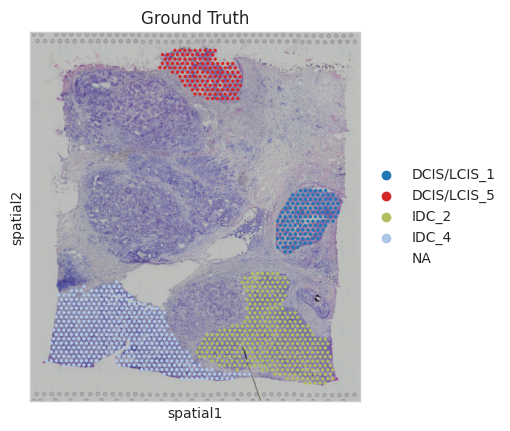

In [15]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"], groups=['DCIS/LCIS_1','DCIS/LCIS_5','IDC_4','IDC_2'])

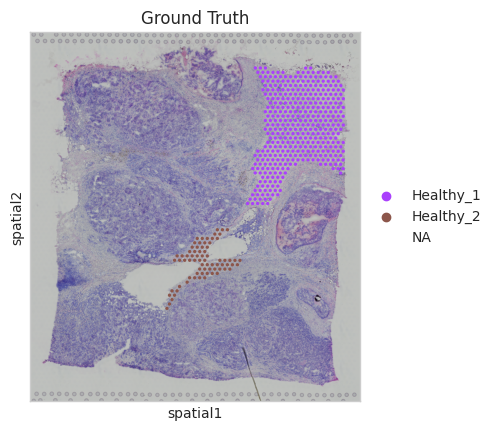

In [16]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"], groups=['Healthy_1','Healthy_2'])# 'Tumor_edge_5'

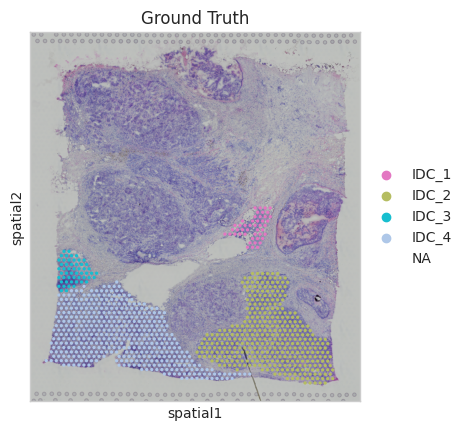

In [17]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"], groups=['IDC_1','IDC_2','IDC_4','IDC_3'])

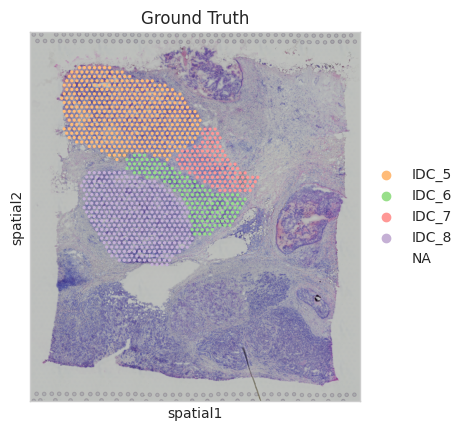

In [18]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"], groups=['IDC_5','IDC_6','IDC_7','IDC_8'])

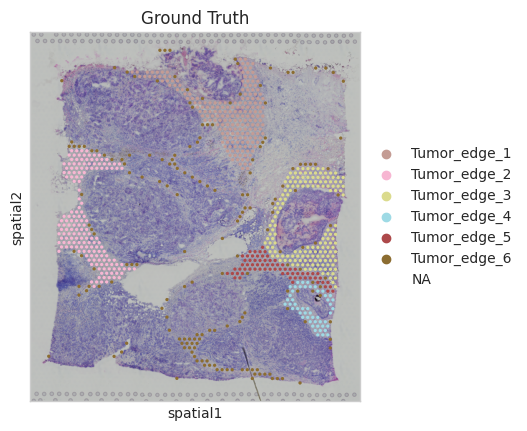

In [19]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"], groups=['Tumor_edge_1','Tumor_edge_2',
                                                                      'Tumor_edge_3','Tumor_edge_4',
                                                                      'Tumor_edge_5','Tumor_edge_6'])

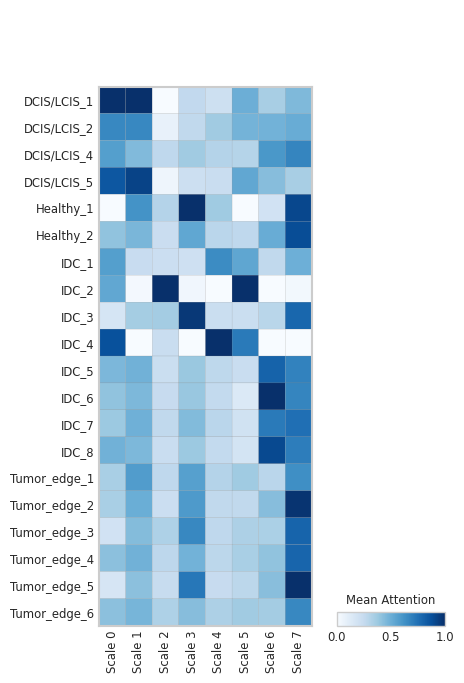

In [20]:
sc.pl.matrixplot(
    adata_attn, 
    var_names=scale_names, 
    groupby='Ground Truth', 
    colorbar_title='Mean Attention',
    cmap='Blues',
    standard_scale='var' # 可选：对每个尺度进行归一化 (0-1)，便于对比
)

In [21]:
attn

array([[3.2567628e-02, 7.7583626e-02, 1.4965078e-01, ..., 3.2277104e-01,
        6.0212702e-02, 1.1446634e-01],
       [1.2901713e-01, 3.9525721e-03, 1.3985924e-01, ..., 3.4719378e-01,
        1.2437747e-03, 4.6123350e-03],
       [2.3162667e-02, 1.3910443e-01, 1.6510884e-01, ..., 2.4617922e-02,
        3.9017759e-02, 1.8592702e-01],
       ...,
       [1.5629341e-01, 3.3447822e-04, 9.7669050e-02, ..., 3.4319127e-01,
        1.9908001e-04, 5.8914936e-04],
       [4.8995800e-02, 1.2631869e-01, 7.3460653e-02, ..., 1.9969735e-01,
        7.1507283e-02, 1.5121904e-01],
       [1.2961234e-01, 1.1083886e-01, 1.1589460e-01, ..., 2.7236718e-01,
        1.2871259e-01, 4.9906198e-02]], dtype=float32)

In [22]:
# attn = np.clip(attn, 1e-10, 1.0)
attn = attn / attn.sum(axis=1, keepdims=True)
weights = np.arange(1, 9)  # 尺度权重
SES = attn @ weights
# SE = -np.sum(attn * np.log(attn), axis=1)
SE = -np.sum(attn * np.log(attn), axis=1)
adata.obs['SES'] = SES
adata.obs['SE'] = SE

[<Axes: title={'center': 'SES'}, xlabel='spatial1', ylabel='spatial2'>]

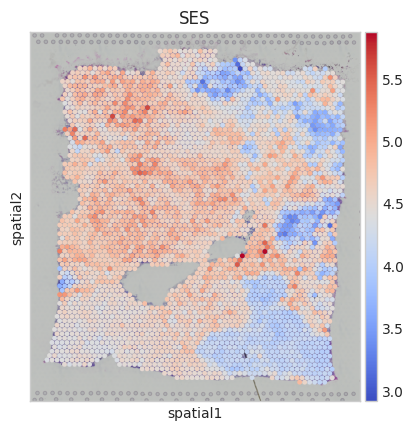

In [23]:
temp_adata = adata.copy()
temp_adata.obs['SES'] = SES
sc.pl.spatial(temp_adata, 
                color='SES',
                show=False, cmap='coolwarm',
                size=1.5)

[<Axes: title={'center': 'SE'}, xlabel='spatial1', ylabel='spatial2'>]

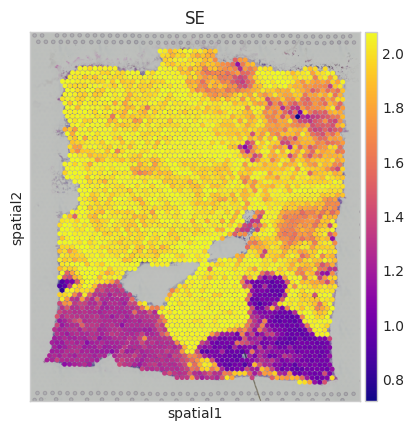

In [24]:
temp_adata = adata.copy()
temp_adata.obs['SE'] = SE
sc.pl.spatial(temp_adata, 
                color='SE',
                show=False, 
                cmap='plasma',
                size=1.5)

IDC1-4 vs IDC5-8

In [25]:

import scanpy as sc
import pandas as pd
import numpy as np

# 1. 创建一个新的子集，只包含 IDC 细胞
# 假设你的标签在 'Ground Truth' 列
idc_sub = adata[adata.obs['Ground Truth'].str.contains('IDC')].copy()

# 2. 定义分组逻辑
def define_idc_group(label):
    # 提取数字部分，例如 "IDC_1" -> 1
    try:
        num = int(label.split('_')[1])
        if 1 <= num <= 4:
            return 'IDC_1-4 (Small Scale)' # 假设这是之前看小尺度的一组
        elif 5 <= num <= 8:
            return 'IDC_5-8 (Large Scale)' # 假设这是之前看大尺度的一组
        else:
            return 'Other'
    except:
        return 'Other'

# 3. 应用分组
idc_sub.obs['IDC_Group'] = idc_sub.obs['Ground Truth'].apply(define_idc_group)

# 检查一下分组数量
print(idc_sub.obs['IDC_Group'].value_counts())

IDC_5-8 (Large Scale)    1103
IDC_1-4 (Small Scale)     924
Name: IDC_Group, dtype: int64


Up-regulated in IDC 5-8: 550 genes
Up-regulated in IDC 1-4: 2548 genes


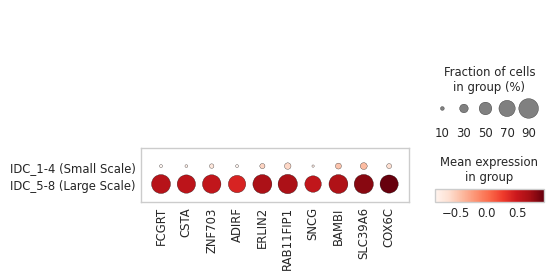

In [26]:
# 1. 确保使用归一化后的数据 (通常是 log1p 后的)
# sc.pp.normalize_total(idc_sub, target_sum=1e4)
# sc.pp.log1p(idc_sub)

# 2. 计算差异基因
# reference='IDC_1-4 (Small Scale)' 意味着：
# 正值 (positive scores) = 在 IDC 5-8 中高表达
# 负值 (negative scores) = 在 IDC 1-4 中高表达
sc.tl.rank_genes_groups(idc_sub, groupby='IDC_Group', method='wilcoxon', 
                        reference='IDC_1-4 (Small Scale)', groups=['IDC_5-8 (Large Scale)'])

# 3. 提取结果为 DataFrame
result = sc.get.rank_genes_groups_df(idc_sub, group='IDC_5-8 (Large Scale)')

# 过滤出显著的基因 (例如 pvals_adj < 0.05 & logfoldchanges > 1)
# 这一步是为了给后面的通路分析做准备
up_genes = result[(result.pvals_adj < 0.05) & (result.logfoldchanges > 0.5)]['names'].tolist()
down_genes = result[(result.pvals_adj < 0.05) & (result.logfoldchanges < -0.5)]['names'].tolist()

print(f"Up-regulated in IDC 5-8: {len(up_genes)} genes")
print(f"Up-regulated in IDC 1-4: {len(down_genes)} genes")

# 4. 可视化：火山图或 DotPlot
# 选出最显著的前 10 个基因画图看看
top_genes = result.head(10)['names'].tolist()
sc.pl.dotplot(idc_sub, top_genes, groupby='IDC_Group', dendrogram=True)

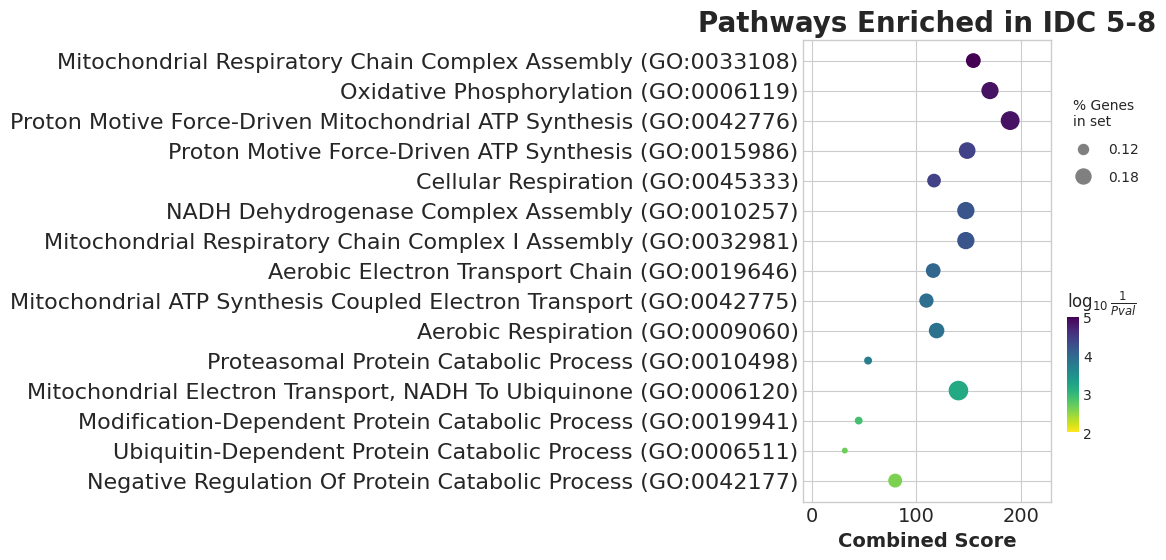

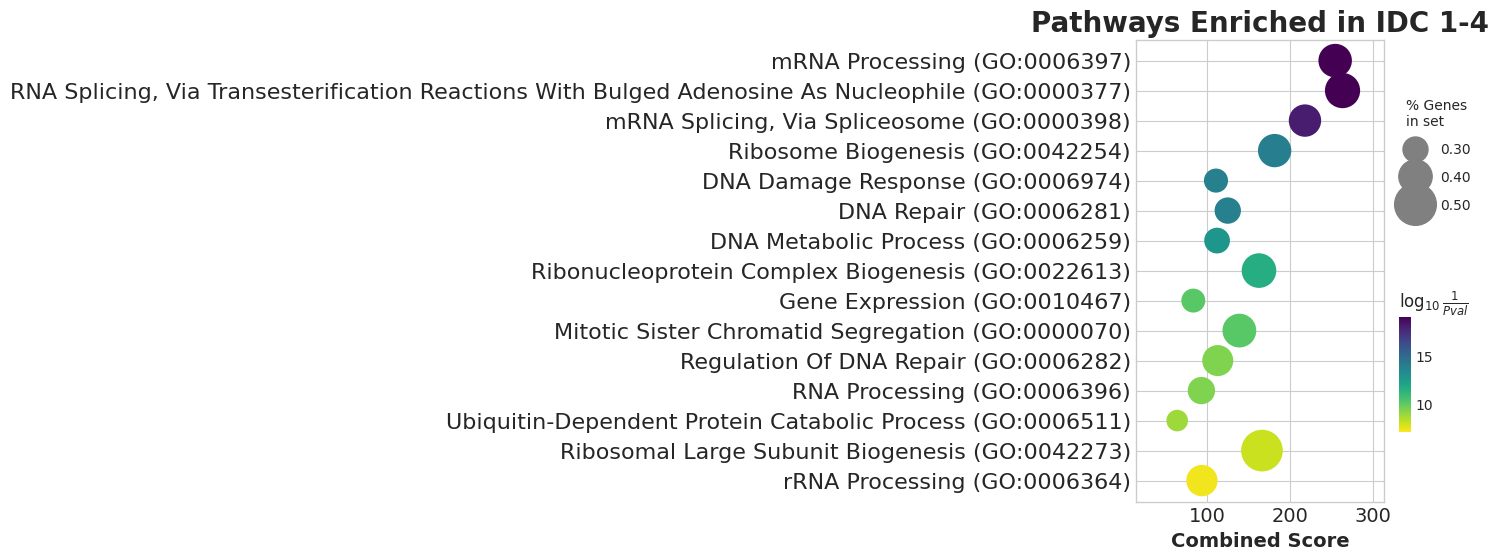

In [27]:
import gseapy as gp
import matplotlib.pyplot as plt

# 选择基因集库：
# 'KEGG_2021_Human', 'MSigDB_Hallmark_2020', 'GO_Biological_Process_2023'
gene_sets = ['MSigDB_Hallmark_2020', 'GO_Biological_Process_2023']

# 1. 分析 IDC 5-8 高表达的通路 (Up-regulated)
enr_up = gp.enrichr(gene_list=up_genes,
                 gene_sets=gene_sets,
                 organism='human', # or 'mouse'
                 outdir=None)

# 2. 分析 IDC 1-4 高表达的通路 (Down-regulated / Base)
enr_down = gp.enrichr(gene_list=down_genes,
                 gene_sets=gene_sets,
                 organism='human',
                 outdir=None)

# 3. 绘图 (Dotplot)
# 展示 IDC 5-8 的前15个显著通路
from gseapy import dotplot
ax = dotplot(enr_up.res2d, title='Pathways Enriched in IDC 5-8', cmap='viridis_r', size=10, top_term=15)
plt.show()

# 展示 IDC 1-4 的前15个显著通路
ax = dotplot(enr_down.res2d, title='Pathways Enriched in IDC 1-4', cmap='viridis_r', size=10, top_term=15)
plt.show()

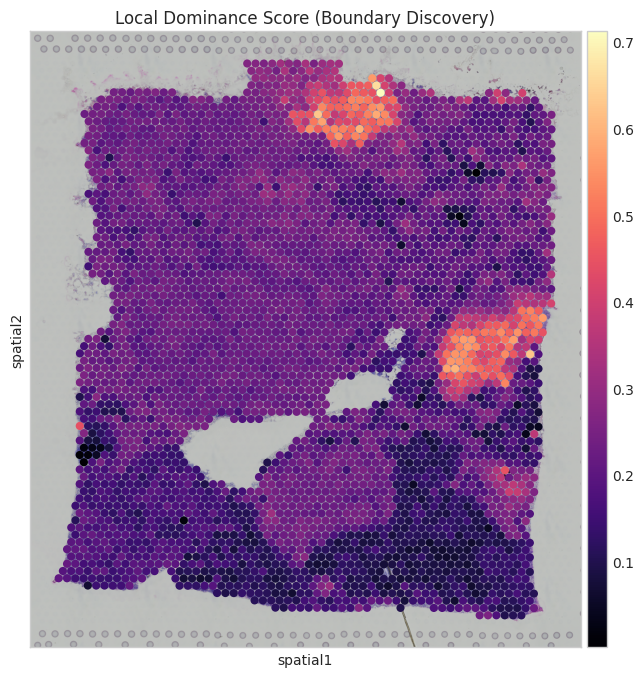

In [28]:
# ==========================================
# 新增功能：计算并可视化局部主导度 (Local Dominance)
# ==========================================

# 1. 定义什么是“局部”尺度
# 这里我们要累加前 k_local_threshold + 1 个尺度的权重
# 如果 k_local_threshold = 1，则累加 k=0 (Self) 和 k=1 (1-hop)
k_local_threshold = 2

# 2. 计算局部主导度得分
# attn 已经是归一化过的 (sum=1)，所以直接累加局部列即可
# attn[:, :2] 取的是第0列和第1列
local_attn_score = np.sum(attn[:, :k_local_threshold], axis=1)

# 3. 将得分保存到 adata.obs 中以便绘图
adata.obs['Local_Dominance'] = local_attn_score

# 4. 可视化
# 使用 'magma' 色谱 (黑色-紫色-亮黄)，亮黄色代表高局部主导度(即潜在的边界)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.spatial(adata, 
              img_key="hires", 
              color='Local_Dominance', 
              cmap='magma', 
              size=1.5, 
              title='Local Dominance Score (Boundary Discovery)',
              ax=ax,
              show=False)

# 可选：保存图片
# plt.savefig('Local_Dominance_Boundary.png', dpi=300, bbox_inches='tight')
plt.show()

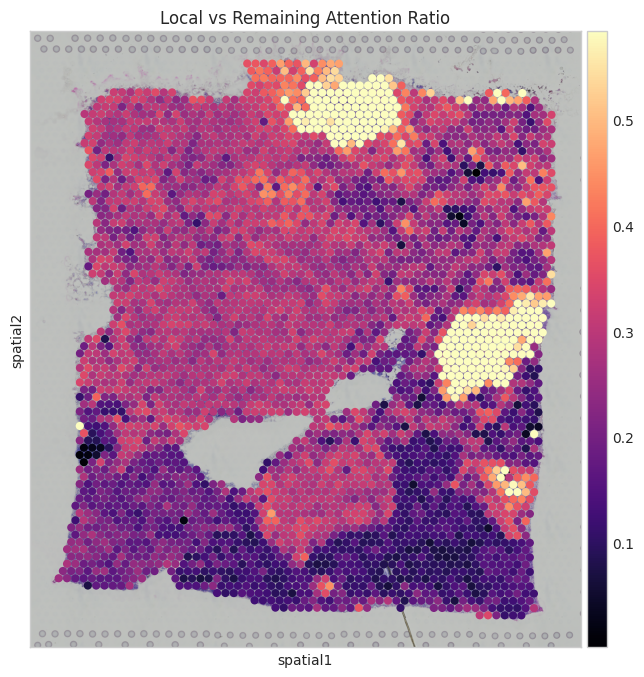

In [29]:
# ==========================================
# 进阶版：计算“局部 vs 剩余”注意力比率 (Local-to-Remaining Ratio)
# ==========================================
import numpy as np

# 1. 定义局部阈值 (k=0 和 k=1 为局部)
k_local_threshold = 2

# 2. 分别计算“局部”和“剩余”的权重和
# 局部 (Local): k <= 1
local_sum = np.sum(attn[:, :k_local_threshold], axis=1)

# 剩余 (Remaining/Global): k > 1
remaining_sum = np.sum(attn[:, k_local_threshold:], axis=1)

# 3. 计算比率 (Ratio)
# 加上一个极小值 1e-6 防止除以零 (如果 remaining_sum 为 0)
# 这个指标的物理含义：局部注意力是长程注意力的多少倍？
# 在边界处，这个值可能会非常大（例如 局部0.9 / 剩余0.1 = 9倍）
ratio_score = local_sum / (remaining_sum + 1e-6)

# (可选) 如果比率极值太大，可以取个 log 压缩一下范围，方便画图
# ratio_score = np.log1p(ratio_score) 

# 4. 保存并画图
adata.obs['Local_Global_Ratio'] = ratio_score

fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.spatial(adata, 
              img_key="hires", 
              color='Local_Global_Ratio', 
              cmap='magma',  # 依然推荐 magma 或 inferno，高值亮黄
              size=1.5,
              # 设定 vmax 可以防止个别极端值掩盖整体趋势，
              # np.percentile(ratio_score, 95) 表示只看前 95% 的数值分布
              vmax=np.percentile(ratio_score, 95), 
              title='Local vs Remaining Attention Ratio',
              ax=ax,
              show=False)

plt.show()